In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def Find_ESS(lambda0):
    # find the ES=E[z] and ESS=E[zz^T]
    N, K = lambda0.shape
    ES = lambda0 
    ESS = lambda0.T @ lambda0 
    ESS = ESS - np.diag(np.diag(ESS)) + np.diag(np.sum(ES, axis=0))

    return ES, ESS


def Find_lambda(X, mu, sigma, pie, lambda0):
    N_, K = lambda0.shape
    lambda_new = lambda0
    diag_mu = np.diag(mu.T@mu).flatten()
    for k in range(K):
        x = (np.log(pie[:, k]/(1-pie[:, k]))
                 + 1 / (sigma**2)
                 * ((X-lambda_new@mu.T)@mu[:, k]
                +lambda_new[:, k]*diag_mu[k]
                - 0.5*diag_mu[k]
                 )
                 )
        lambda_new[:, k] = 1/(1+np.exp(-x))
    return lambda_new

def Find_Free_Energy(X, mu, sigma, pie, lambda0):
    # Compute the free energy
    N, D = X.shape # Number of samples and dimensionality
    _, K = lambda0.shape # Number of clusters

    # Regularize lambda0 to avoid numerical issues

    lambda0[lambda0 >= 1] = 1 - 1e-12
    lambda0[lambda0 <= 0] = 1e-12

    # Compute ES and ESS
    ES, ESS = Find_ESS(lambda0)

    # Free energy calculation
    F = - 0.5 * N * D * np.log(2 * np.pi * sigma**2)  # Constant term
    F -= 0.5 / sigma**2 * (
        np.trace(X.T @ X) +
        np.trace(mu.T @ mu @ ESS) -
        2 * np.trace(ES.T @ X @ mu)
    )  # Quadratic term
    F += np.sum(lambda0 * np.log(pie/lambda0) + (1 - lambda0) * np.log((1 - pie)/(1 - lambda0)))
      # Prior and entropy term

    return F

def MeanField(X, mu, sigma, pie, lambda0, maxsteps):
    # track the free energy
    Fs = []
    lambda_old = lambda0
    # early stopping
    eplison = 1e-10
    for i in range(maxsteps):
        lambda_new = Find_lambda(X, mu, sigma, pie, lambda_old)
        F = Find_Free_Energy(X, mu, sigma, pie, lambda_new)
        Fs.append(F)
        if i > 10 and np.abs(Fs[-1] - Fs[-2]) < eplison:
            break
        lambda_old = lambda_new
    return lambda_old, Fs



In [3]:
def m_step(X, ES, ESS):
    """
    mu, sigma, pie = MStep(X,ES,ESS)

    Inputs:
    -----------------
           X: shape (N, D) data matrix
          ES: shape (N, K) E_q[s]
         ESS: shape (K, K) sum over data points of E_q[ss'] (N, K, K)
                           if E_q[ss'] is provided, the sum over N is done for you.

    Outputs:
    --------
          mu: shape (D, K) matrix of means in p(y|{s_i},mu,sigma)
       sigma: shape (,)    standard deviation in same
         pie: shape (1, K) vector of parameters specifying generative distribution for s
    """
    N, D = X.shape
    if ES.shape[0] != N:
        raise TypeError('ES must have the same number of rows as X')
    K = ES.shape[1]
    if ESS.shape == (N, K, K):
        ESS = np.sum(ESS, axis=0)
    if ESS.shape != (K, K):
        raise TypeError('ESS must be square and have the same number of columns as ES')

    mu = np.dot(np.dot(np.linalg.inv(ESS), ES.T), X).T
    sigma = np.sqrt((np.trace(np.dot(X.T, X)) + np.trace(np.dot(np.dot(mu.T, mu), ESS))
                     - 2 * np.trace(np.dot(np.dot(ES.T, X), mu))) / (N * D))
    pie = np.mean(ES, axis=0, keepdims=True)
    
    return mu, sigma, pie

In [4]:
def LearnBinFactors(X, K, iterations):
    # LearnBinFactors learns the parameters of a binary factor analysis model
    N, D = X.shape
    random_seed = 42
    
    # Initialize parameters
    lambda_ = np.random.rand(N, K)  # Shape (N, K)
    ES, ESS = Find_ESS(lambda_)
    # Generate values for mu, sigma, pie
    mu, sigma, pie = m_step(X, ES, ESS)
    # Keep track of free energy
    F_list = []

    for it in range(iterations):
        print(f"Iteration {it+1}:")

        # E-step: Update lambda using MeanField
        lambda_, Fs = MeanField(X, mu, sigma, pie, lambda_, maxsteps=300)
        F = Fs[-1]
        # M-step: Update parameters
        ES, ESS = Find_ESS(lambda_)
        mu, sigma, pie = m_step(X, ES, ESS)

        # Keep track of free energy
        F_list.append(F)
        print(f"Free Energy = {F}")

        # stopping criterion
        if it > 2:
            if F_list[-1]-F_list[-2] < 1e-100:
                print("Reached cut-off after {} iterations".format(it))
                break
            # check for increase in F
            assert F_list[-1] >= F_list[-2]

    # Plot free energy
    plt.plot(F_list)
    plt.xlabel("Iteration")
    plt.ylabel("Free Energy")
    plt.grid()
    plt.title("Free Energy vs. Iteration")
    plt.savefig("free_energy.png")
    plt.show()
    

    return mu, sigma, pie, lambda_


In [5]:
def generate_feature_data(N=400, D=16, seed=0):



    np.random.seed(seed)

  # Define the basic shapes of the features

    m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

    m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

    m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

    m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

    m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

    m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

    m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

    m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

    nfeat = 8 # number of features
    rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
    mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
    s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

    # Generate Data - The Data is stored in Y

    Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

    nrows = 13
    for k in range(16):
        plt.subplot(4, 4, k + 1)
        plt.imshow(np.reshape(Y[k], (4, 4)), cmap=plt.gray(), interpolation='none')
        plt.axis('off')

    plt.show()

    return Y

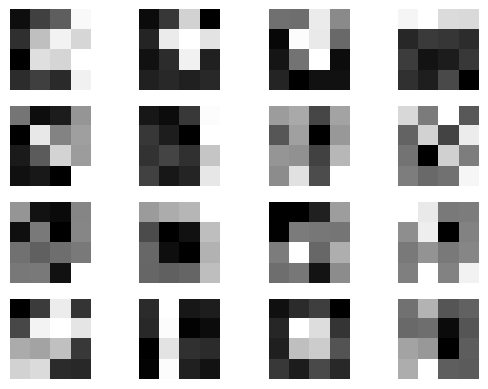

Iteration 1:
Free Energy = -5443.330737308778
Iteration 2:
Free Energy = -4908.335400466809
Iteration 3:
Free Energy = -4323.884142287223
Iteration 4:
Free Energy = -3675.127946189753
Iteration 5:
Free Energy = -3224.9957266503507
Iteration 6:
Free Energy = -2940.258216818749
Iteration 7:
Free Energy = -2771.9350463221695
Iteration 8:
Free Energy = -2678.5078142108323
Iteration 9:
Free Energy = -2615.8119340776234
Iteration 10:
Free Energy = -2560.3328103751196
Iteration 11:
Free Energy = -2525.9607795698403
Iteration 12:
Free Energy = -2508.803560108311
Iteration 13:
Free Energy = -2498.5462763754153
Iteration 14:
Free Energy = -2492.1286148474337
Iteration 15:
Free Energy = -2486.8326857712577
Iteration 16:
Free Energy = -2477.1292810270006
Iteration 17:
Free Energy = -2465.6714147261514
Iteration 18:
Free Energy = -2452.549165781812
Iteration 19:
Free Energy = -2447.171635903234
Iteration 20:
Free Energy = -2445.0054307777805
Iteration 21:
Free Energy = -2444.2479919437146
Iteration

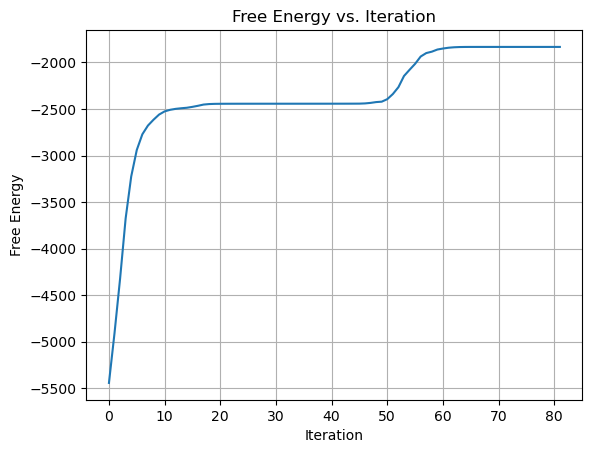

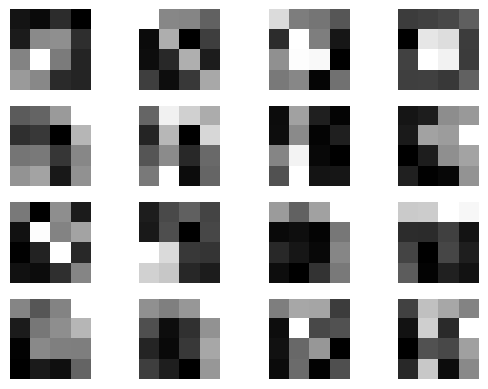

Iteration 1:
Free Energy = -3917.0095473966094
Iteration 2:
Free Energy = -3510.0639465011745
Iteration 3:
Free Energy = -2868.44552826655
Iteration 4:
Free Energy = -2382.988925689973
Iteration 5:
Free Energy = -1900.9869979739783
Iteration 6:
Free Energy = -1473.4687312717538
Iteration 7:
Free Energy = -1289.055149109622
Iteration 8:
Free Energy = -1190.1506793829822
Iteration 9:
Free Energy = -1111.7200492742227
Iteration 10:
Free Energy = -1062.4779289270896
Iteration 11:
Free Energy = -1010.5124693438443
Iteration 12:
Free Energy = -902.1327343255257
Iteration 13:
Free Energy = -858.1573974594644
Iteration 14:
Free Energy = -847.3053251394977
Iteration 15:
Free Energy = -827.9099817494834
Iteration 16:
Free Energy = -809.0660257071345
Iteration 17:
Free Energy = -788.3279004069941
Iteration 18:
Free Energy = -778.058385550868
Iteration 19:
Free Energy = -765.8279264940584
Iteration 20:
Free Energy = -749.4392437044835
Iteration 21:
Free Energy = -735.7825548153146
Iteration 22:
Fr

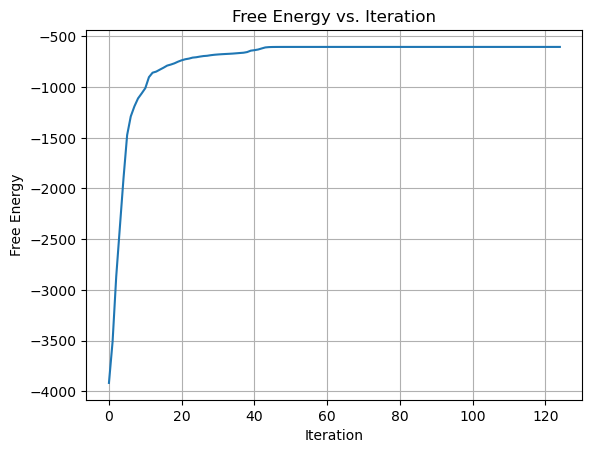

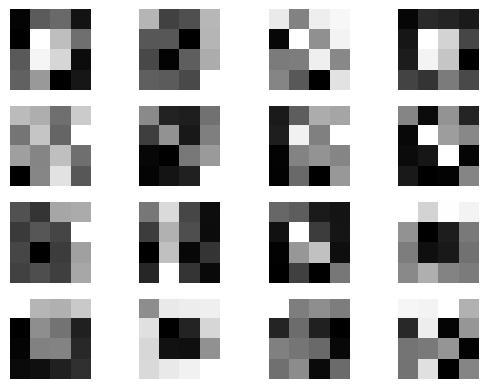

Iteration 1:
Free Energy = -4617.483142613577
Iteration 2:
Free Energy = -4039.977453909185
Iteration 3:
Free Energy = -3407.0405750643167
Iteration 4:
Free Energy = -2627.814466337185
Iteration 5:
Free Energy = -2105.1557453469454
Iteration 6:
Free Energy = -1840.6839376889614
Iteration 7:
Free Energy = -1685.7636667992347
Iteration 8:
Free Energy = -1584.1622955966923
Iteration 9:
Free Energy = -1497.715391262178
Iteration 10:
Free Energy = -1413.6991958011579
Iteration 11:
Free Energy = -1339.0169798394875
Iteration 12:
Free Energy = -1298.8335807423814
Iteration 13:
Free Energy = -1267.2013296994937
Iteration 14:
Free Energy = -1236.5389739298198
Iteration 15:
Free Energy = -1210.888664716765
Iteration 16:
Free Energy = -1171.9367111210886
Iteration 17:
Free Energy = -1123.2144931894159
Iteration 18:
Free Energy = -1032.5376957067324
Iteration 19:
Free Energy = -954.7354992787718
Iteration 20:
Free Energy = -924.4515370945787
Iteration 21:
Free Energy = -909.9119260553725
Iteration

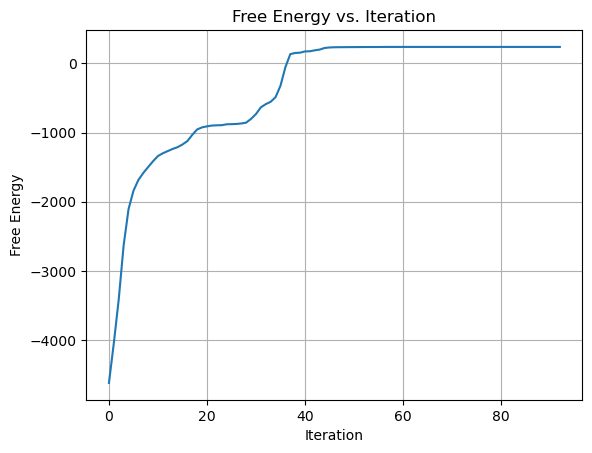

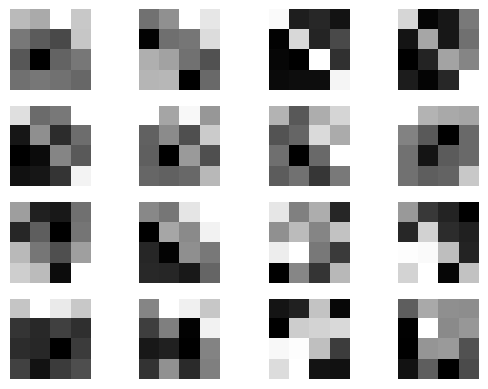

Iteration 1:
Free Energy = -5344.069961998192
Iteration 2:
Free Energy = -4642.302831594918
Iteration 3:
Free Energy = -3724.899634502615
Iteration 4:
Free Energy = -2902.916484054388
Iteration 5:
Free Energy = -2316.4674813982615
Iteration 6:
Free Energy = -1965.4820443513067
Iteration 7:
Free Energy = -1717.9370016449484
Iteration 8:
Free Energy = -1408.5012418493152
Iteration 9:
Free Energy = -861.8831376057065
Iteration 10:
Free Energy = -462.9294287699465
Iteration 11:
Free Energy = -231.2664071094273
Iteration 12:
Free Energy = -158.21486498556487
Iteration 13:
Free Energy = -132.34256483427862
Iteration 14:
Free Energy = -107.59428384984722
Iteration 15:
Free Energy = -100.56667903198877
Iteration 16:
Free Energy = -97.68177083672981
Iteration 17:
Free Energy = -95.82516397401514
Iteration 18:
Free Energy = -73.12768105687746
Iteration 19:
Free Energy = -69.1118554501295
Iteration 20:
Free Energy = -68.7035792740271
Iteration 21:
Free Energy = -68.55604519525923
Iteration 22:
Fr

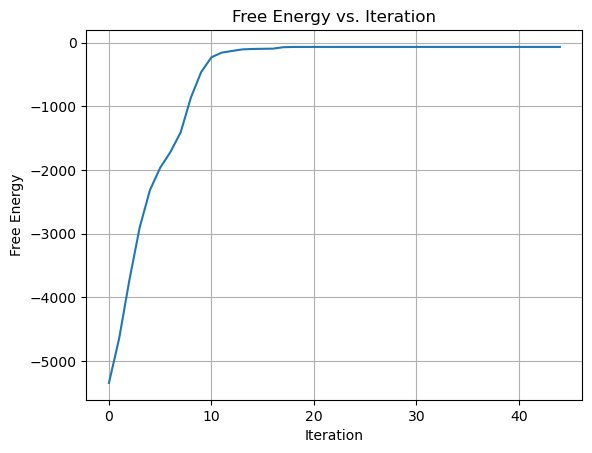

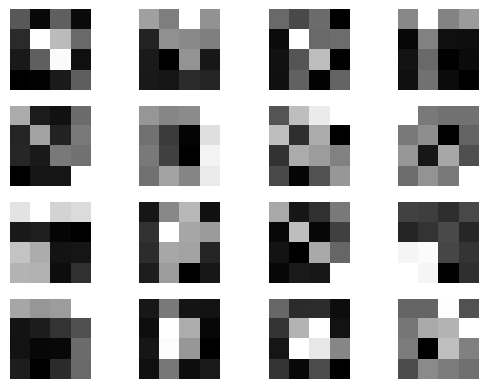

Iteration 1:
Free Energy = -5468.346378479344
Iteration 2:
Free Energy = -4946.708751278059
Iteration 3:
Free Energy = -4357.388858938558
Iteration 4:
Free Energy = -3675.4937019699178
Iteration 5:
Free Energy = -3044.270338066526
Iteration 6:
Free Energy = -2752.946258649322
Iteration 7:
Free Energy = -2572.0516653308932
Iteration 8:
Free Energy = -2431.72788603237
Iteration 9:
Free Energy = -2366.581691189915
Iteration 10:
Free Energy = -2333.6749686490884
Iteration 11:
Free Energy = -2320.6445913784128
Iteration 12:
Free Energy = -2312.5916212147754
Iteration 13:
Free Energy = -2309.0570973996937
Iteration 14:
Free Energy = -2307.2840191690902
Iteration 15:
Free Energy = -2305.5274909939867
Iteration 16:
Free Energy = -2294.801618101454
Iteration 17:
Free Energy = -2286.3137294594876
Iteration 18:
Free Energy = -2281.1696494393186
Iteration 19:
Free Energy = -2273.279121630222
Iteration 20:
Free Energy = -2265.5700532460037
Iteration 21:
Free Energy = -2261.6829534009566
Iteration 2

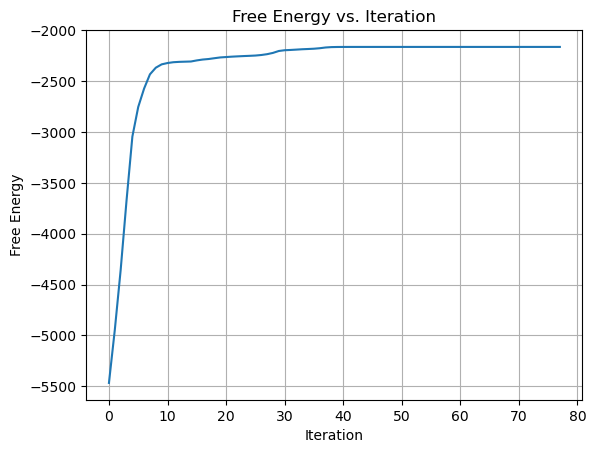

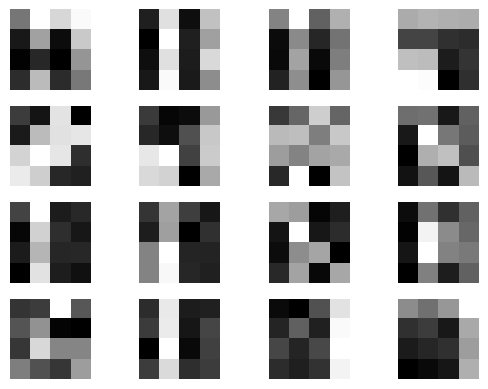

Iteration 1:
Free Energy = -5311.70708984974
Iteration 2:
Free Energy = -4837.051073795467
Iteration 3:
Free Energy = -4192.8108580283415
Iteration 4:
Free Energy = -3613.150796320664
Iteration 5:
Free Energy = -3133.6048193337137
Iteration 6:
Free Energy = -2835.9338186860778
Iteration 7:
Free Energy = -2680.7324328479153
Iteration 8:
Free Energy = -2597.299629080499
Iteration 9:
Free Energy = -2534.729184808608
Iteration 10:
Free Energy = -2484.817428186275
Iteration 11:
Free Energy = -2436.023194807834
Iteration 12:
Free Energy = -2371.323777651981
Iteration 13:
Free Energy = -2274.868789164363
Iteration 14:
Free Energy = -2206.1514698017354
Iteration 15:
Free Energy = -2156.0291284721447
Iteration 16:
Free Energy = -2115.4011685621745
Iteration 17:
Free Energy = -2068.3803828439454
Iteration 18:
Free Energy = -2029.0359408867484
Iteration 19:
Free Energy = -1991.1789614857369
Iteration 20:
Free Energy = -1968.8606583550763
Iteration 21:
Free Energy = -1942.8371564082895
Iteration 2

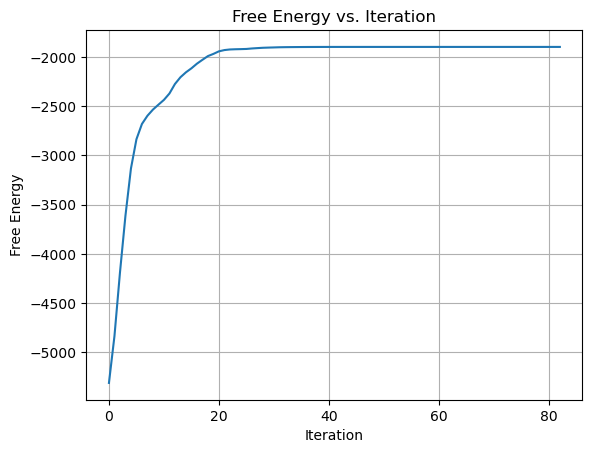

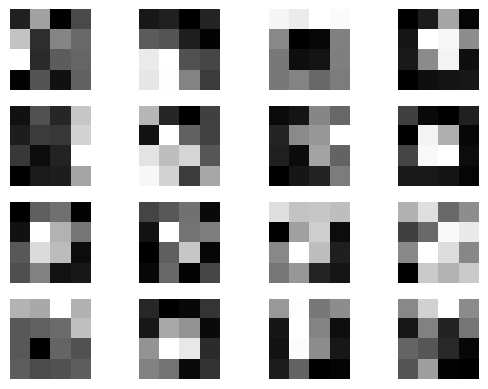

Iteration 1:
Free Energy = -5112.928504688219
Iteration 2:
Free Energy = -4645.37849541498
Iteration 3:
Free Energy = -3845.540567173221
Iteration 4:
Free Energy = -2901.0279971027676
Iteration 5:
Free Energy = -2310.978238710902
Iteration 6:
Free Energy = -2010.962938139765
Iteration 7:
Free Energy = -1781.3209980924603
Iteration 8:
Free Energy = -1581.3939806368562
Iteration 9:
Free Energy = -1483.5422348517159
Iteration 10:
Free Energy = -1429.9266095845428
Iteration 11:
Free Energy = -1396.0645087908092
Iteration 12:
Free Energy = -1368.6810592093084
Iteration 13:
Free Energy = -1344.340045150534
Iteration 14:
Free Energy = -1314.8681935192926
Iteration 15:
Free Energy = -1290.1847310616304
Iteration 16:
Free Energy = -1250.8948922926443
Iteration 17:
Free Energy = -1224.7155625679957
Iteration 18:
Free Energy = -1187.5327907260234
Iteration 19:
Free Energy = -1170.979246403308
Iteration 20:
Free Energy = -1168.0965370571098
Iteration 21:
Free Energy = -1167.940821027179
Iteration 

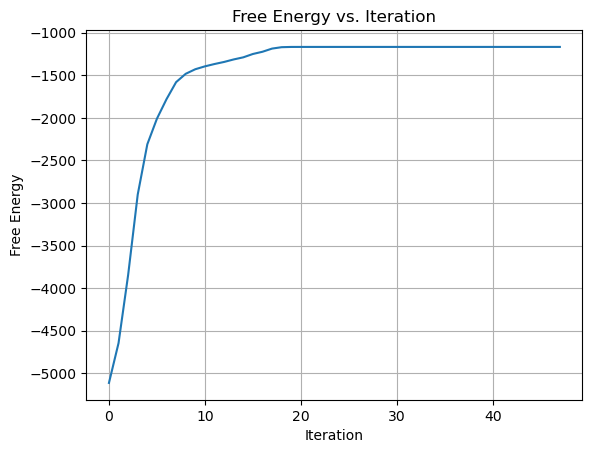

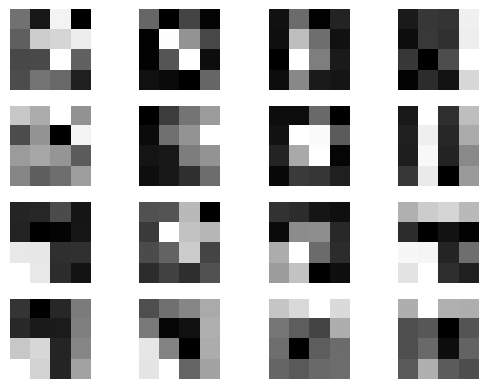

Iteration 1:
Free Energy = -5246.267274405087
Iteration 2:
Free Energy = -4753.513711556403
Iteration 3:
Free Energy = -3877.8121059151954
Iteration 4:
Free Energy = -3084.7438025741303
Iteration 5:
Free Energy = -2631.250807483293
Iteration 6:
Free Energy = -2306.4579344756185
Iteration 7:
Free Energy = -2059.0950651563007
Iteration 8:
Free Energy = -1876.631694735184
Iteration 9:
Free Energy = -1755.9345492953694
Iteration 10:
Free Energy = -1691.2074290296978
Iteration 11:
Free Energy = -1593.0848127104696
Iteration 12:
Free Energy = -1450.7321394659825
Iteration 13:
Free Energy = -1357.1269263117779
Iteration 14:
Free Energy = -1314.0020317101007
Iteration 15:
Free Energy = -1299.2149340709402
Iteration 16:
Free Energy = -1288.7923718588754
Iteration 17:
Free Energy = -1267.0183521491272
Iteration 18:
Free Energy = -1256.2936311513317
Iteration 19:
Free Energy = -1252.4681899246134
Iteration 20:
Free Energy = -1251.2861578940256
Iteration 21:
Free Energy = -1250.7035158663484
Itera

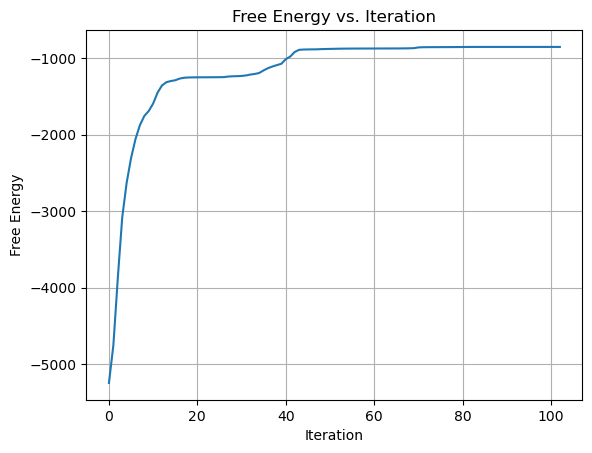

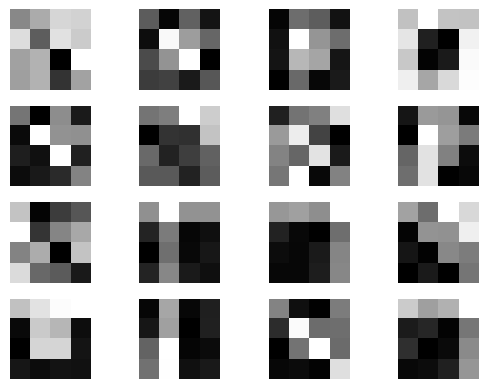

Iteration 1:
Free Energy = -4904.760574700454
Iteration 2:
Free Energy = -4379.103556851845
Iteration 3:
Free Energy = -3714.8491081741495
Iteration 4:
Free Energy = -3092.317627834837
Iteration 5:
Free Energy = -2627.268840221008
Iteration 6:
Free Energy = -2352.8119399899338
Iteration 7:
Free Energy = -2173.5856459306688
Iteration 8:
Free Energy = -2036.342689472648
Iteration 9:
Free Energy = -1961.7015714296408
Iteration 10:
Free Energy = -1904.2367346672395
Iteration 11:
Free Energy = -1857.8786904346166
Iteration 12:
Free Energy = -1831.4514860143113
Iteration 13:
Free Energy = -1804.7742817297067
Iteration 14:
Free Energy = -1788.4495852256655
Iteration 15:
Free Energy = -1768.3893235973014
Iteration 16:
Free Energy = -1757.6876192584132
Iteration 17:
Free Energy = -1741.869022712061
Iteration 18:
Free Energy = -1738.313691869455
Iteration 19:
Free Energy = -1735.9280682636013
Iteration 20:
Free Energy = -1733.3695063887144
Iteration 21:
Free Energy = -1729.1629892388619
Iteratio

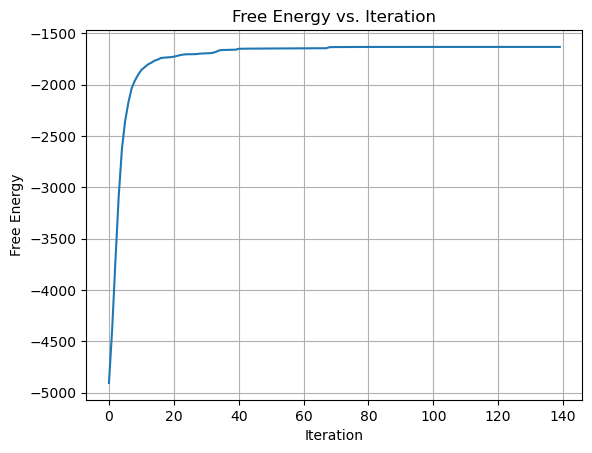

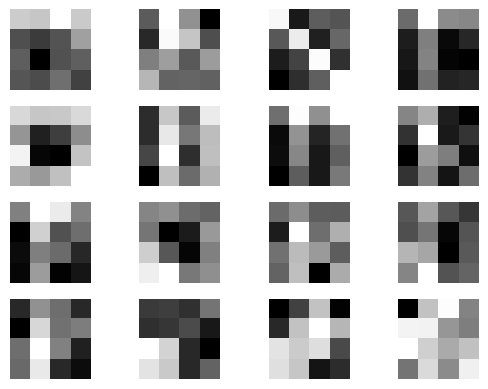

Iteration 1:
Free Energy = -3896.8951143065005
Iteration 2:
Free Energy = -3396.831647918304
Iteration 3:
Free Energy = -2728.0195648039744
Iteration 4:
Free Energy = -2140.97197174317
Iteration 5:
Free Energy = -1682.5935736522429
Iteration 6:
Free Energy = -1446.8939515497782
Iteration 7:
Free Energy = -1352.9849904858434
Iteration 8:
Free Energy = -1312.9946156978358
Iteration 9:
Free Energy = -1292.2637531831265
Iteration 10:
Free Energy = -1273.4678777043705
Iteration 11:
Free Energy = -1254.8230104960471
Iteration 12:
Free Energy = -1233.7245743345416
Iteration 13:
Free Energy = -1209.1473595743496
Iteration 14:
Free Energy = -1182.1140242093093
Iteration 15:
Free Energy = -1159.5197392340224
Iteration 16:
Free Energy = -1142.2110768694301
Iteration 17:
Free Energy = -1126.1720977255595
Iteration 18:
Free Energy = -1115.526889253375
Iteration 19:
Free Energy = -1104.8982986101691
Iteration 20:
Free Energy = -1103.775112490754
Iteration 21:
Free Energy = -1103.4867298481681
Iterat

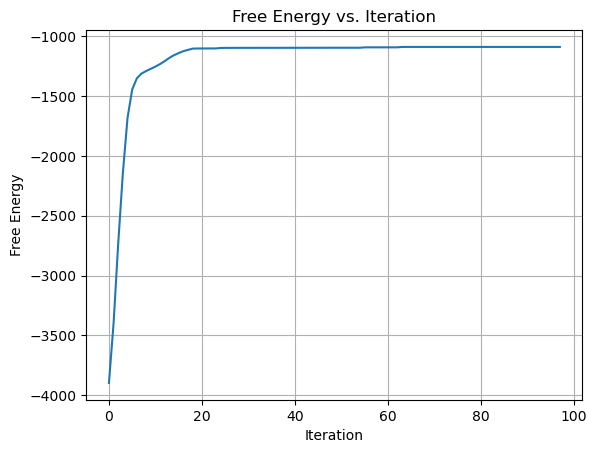

In [6]:
K = 8
# test for different data
F_list = []
mu_list = []
for i in range(10):
    Y = generate_feature_data(seed = i)
    mu, sigma, pie, lambda_ = LearnBinFactors(Y, K, 300)
    F = Find_Free_Energy(Y, mu, sigma, pie, lambda_)
    F_list.append(F)
    mu_list.append(mu)





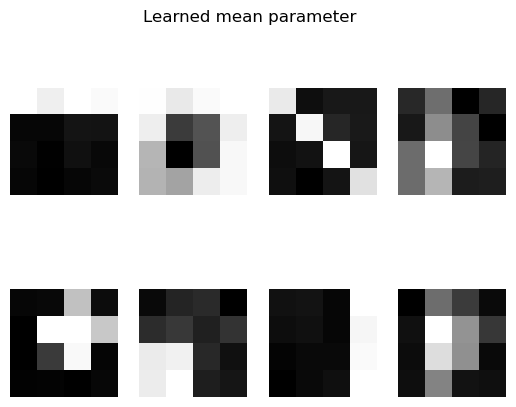

In [7]:
i = np.argmax(F_list)
mu = mu_list[i]
plt.figure()
for k in range(K):
    plt.subplot(int(K/4), int(K/2), k + 1)
    plt.imshow(np.reshape(mu[:, k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.suptitle("Learned mean parameter")
plt.savefig("best_mu_in_10_run.png")
plt.show()


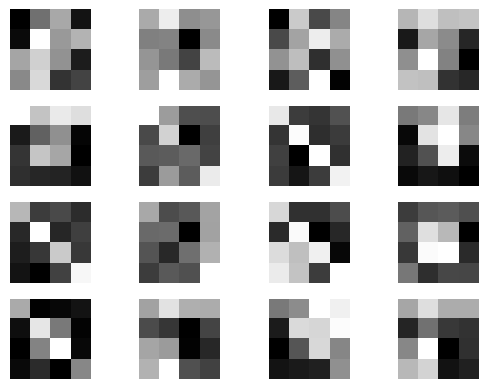

Iteration 1:
Free Energy = -4951.677977756502
Iteration 2:
Free Energy = -4541.338108285804
Iteration 3:
Free Energy = -3929.9274354489266
Iteration 4:
Free Energy = -3227.7422670604083
Iteration 5:
Free Energy = -2626.6009442756886
Iteration 6:
Free Energy = -2255.2149307402233
Iteration 7:
Free Energy = -2059.485407721036
Iteration 8:
Free Energy = -1941.9501394916538
Iteration 9:
Free Energy = -1848.189913162319
Iteration 10:
Free Energy = -1776.2942803799478
Iteration 11:
Free Energy = -1716.6387471374078
Iteration 12:
Free Energy = -1662.193570315569
Iteration 13:
Free Energy = -1606.4097744255482
Iteration 14:
Free Energy = -1579.2427910294355
Iteration 15:
Free Energy = -1562.9570994775
Iteration 16:
Free Energy = -1551.5064745938262
Iteration 17:
Free Energy = -1539.1350043770476
Iteration 18:
Free Energy = -1515.5261360188397
Iteration 19:
Free Energy = -1503.1561346957174
Iteration 20:
Free Energy = -1496.0271461575899
Iteration 21:
Free Energy = -1469.3451365927208
Iteration

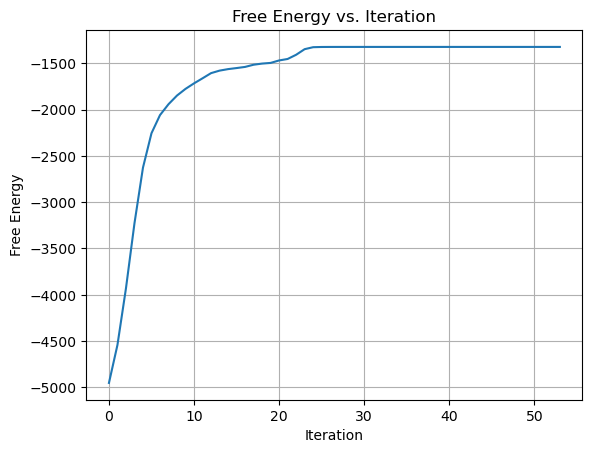

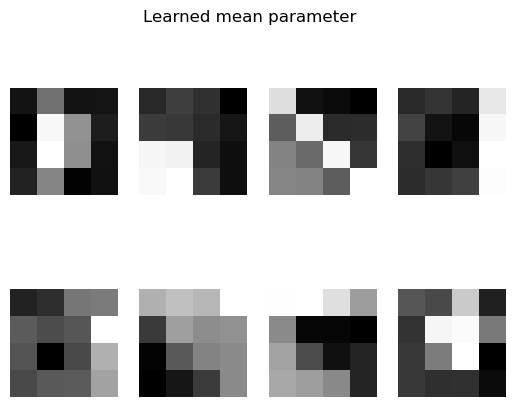

In [8]:
# generate test
Y = generate_feature_data(seed = 10)
mu, sigma, pie, lambda_ = LearnBinFactors(Y, K, 300)

plt.figure()
for k in range(K):
    plt.subplot(int(K/4), int(K/2), k + 1)
    plt.imshow(np.reshape(mu[:, k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.suptitle("Learned mean parameter")
plt.savefig("mu_test.png")
plt.show()

In [9]:
N = 10
K = 3
print(np.random.rand(N, K))

[[0.82033497 0.88788839 0.641368  ]
 [0.46952112 0.32765613 0.57073293]
 [0.3484681  0.79104222 0.69198851]
 [0.21744278 0.07259452 0.85223104]
 [0.6430197  0.74507223 0.1487173 ]
 [0.03015591 0.78151257 0.33199555]
 [0.92481681 0.64022516 0.54035523]
 [0.41538851 0.49737511 0.1956405 ]
 [0.8524222  0.24818558 0.581172  ]
 [0.13093102 0.66790137 0.67309344]]


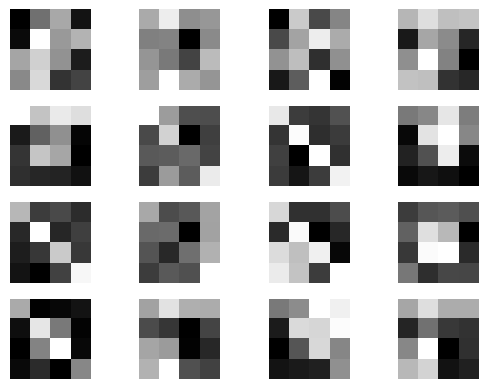

Iteration 1:
Free Energy = -5222.796278877666
Iteration 2:
Free Energy = -4602.030714870361
Iteration 3:
Free Energy = -4147.753373077984
Iteration 4:
Free Energy = -4008.619349047355
Iteration 5:
Free Energy = -3929.330376726019
Iteration 6:
Free Energy = -3884.5384429012793
Iteration 7:
Free Energy = -3854.7279637732395
Iteration 8:
Free Energy = -3823.080245519451
Iteration 9:
Free Energy = -3805.536688123886
Iteration 10:
Free Energy = -3800.770375025423
Iteration 11:
Free Energy = -3795.1327611738407
Iteration 12:
Free Energy = -3792.238772374725
Iteration 13:
Free Energy = -3790.5261471868
Iteration 14:
Free Energy = -3789.9370554082016
Iteration 15:
Free Energy = -3789.817079167862
Iteration 16:
Free Energy = -3789.771018757643
Iteration 17:
Free Energy = -3789.748755174411
Iteration 18:
Free Energy = -3789.737215705123
Iteration 19:
Free Energy = -3789.7310844446147
Iteration 20:
Free Energy = -3789.7277859927526
Iteration 21:
Free Energy = -3789.7259969921006
Iteration 22:
Fre

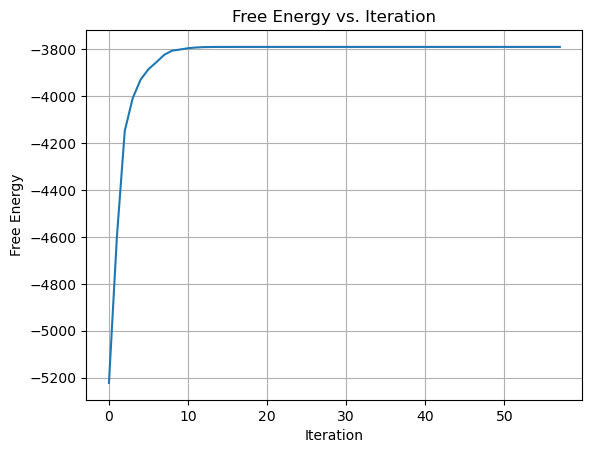

In [13]:
# Single data point X_1 (N=1)
Y = generate_feature_data(seed = 10)

# Initialize parameters
sigma_values = [0.1, 0.5, 1, 5]
maxsteps = 100

# Store results for each sigma
results = {}
mu, sigma, pie, lambd = LearnBinFactors(Y, K, 300)
sigma_values.append(sigma)
for sigma in sigma_values:
    # Run MeanField for a single data point
    lambda0 = np.random.rand(1, K)  # Initialize lambda for N=1
    lambd, F_list = MeanField(Y[0,:][None, :], mu, sigma, pie, lambd[0,:][None,:], 100)
    
    # Compute log difference of F
    log_differences = [np.log(F_list[i] - F_list[i - 1]+1e-10) if i > 0 else None for i in range(len(F_list))]
    
    # Store results
    results[sigma] = {
        "F_list": F_list,
        "log_differences": log_differences
    }


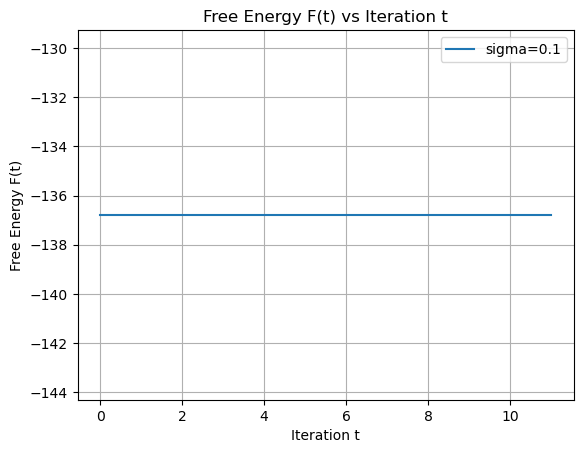

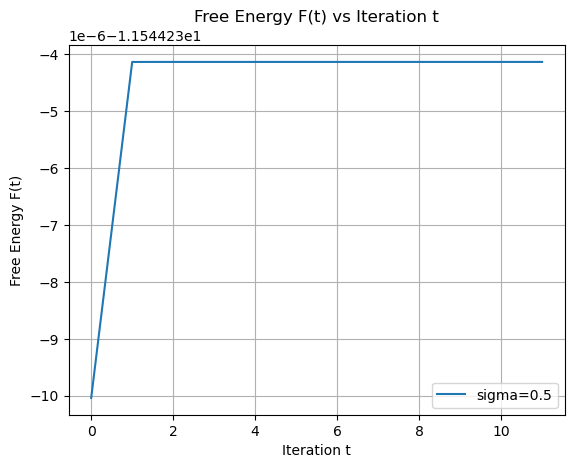

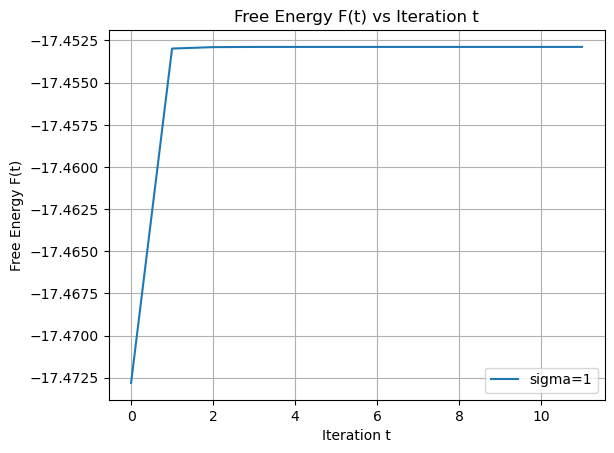

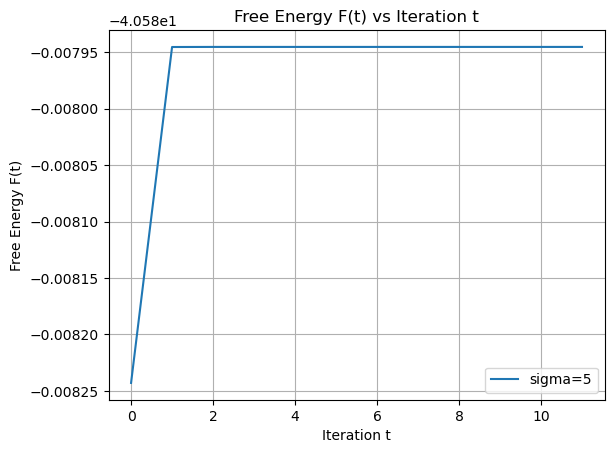

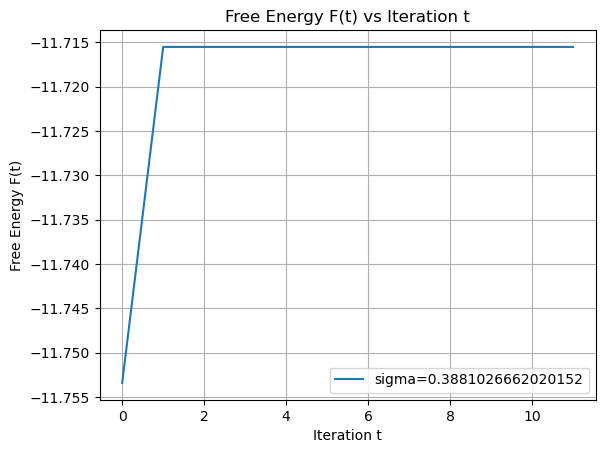

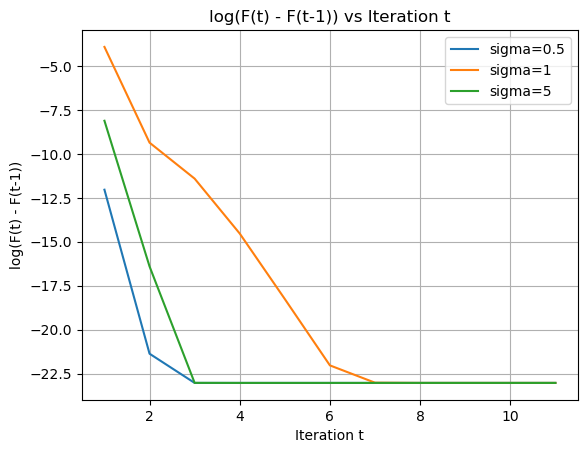

In [18]:

# Plot F(t) for each sigma
#plt.figure(figsize=(12, 6))
for sigma, data in results.items():
    #plt.figure(figsize=(10, 8))
    plt.plot(data["F_list"], label=f'sigma={sigma}')
    plt.xlabel('Iteration t')
    plt.ylabel('Free Energy F(t)')
    plt.title('Free Energy F(t) vs Iteration t')
    plt.grid()
    plt.legend()
    # save for each sigma
    plt.savefig(f"free_energy_sigma_{sigma}.png")
    plt.show()

# Plot log(F(t) - F(t-1)) for each sigma
#plt.figure(figsize=(12, 6))
for sigma in [0.5, 1, 5]:
    data = results[sigma]
    plt.plot(data["log_differences"], label=f'sigma={sigma}')
    plt.xlabel('Iteration t')
    plt.ylabel('log(F(t) - F(t-1))')
    plt.title('log(F(t) - F(t-1)) vs Iteration t')
    plt.legend()
    plt.grid()
    # save for each sigma
plt.savefig('combined_log_diff.png')
plt.show()

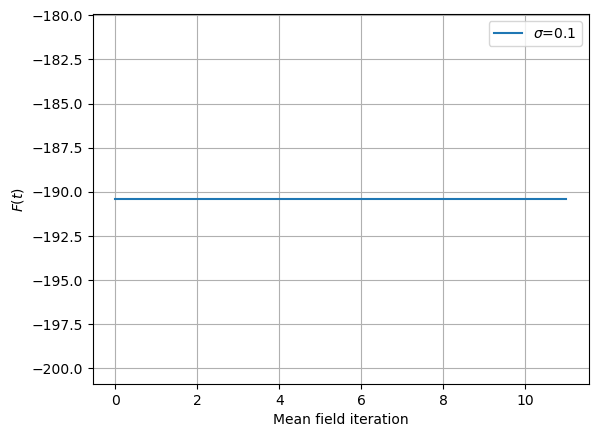

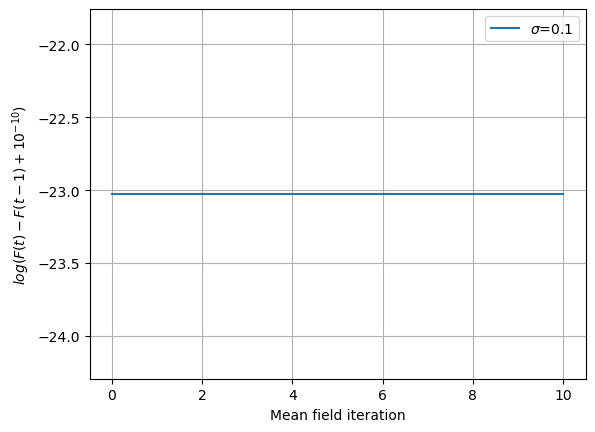

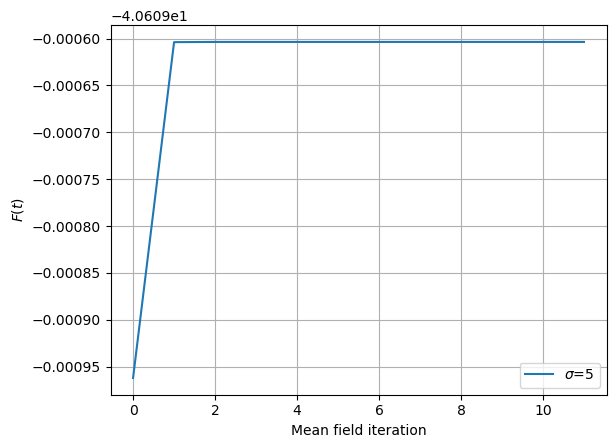

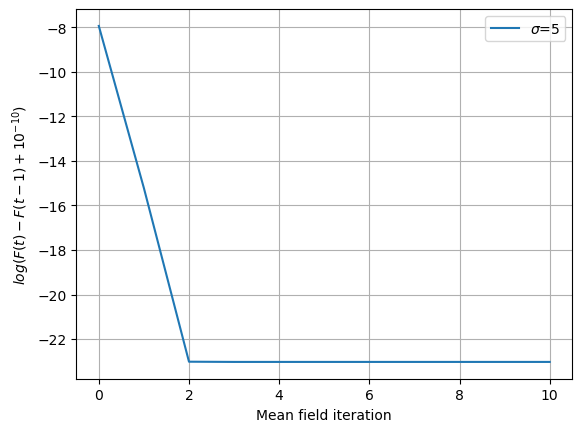

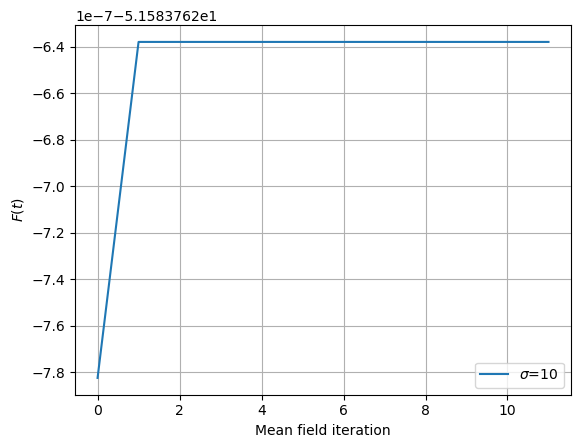

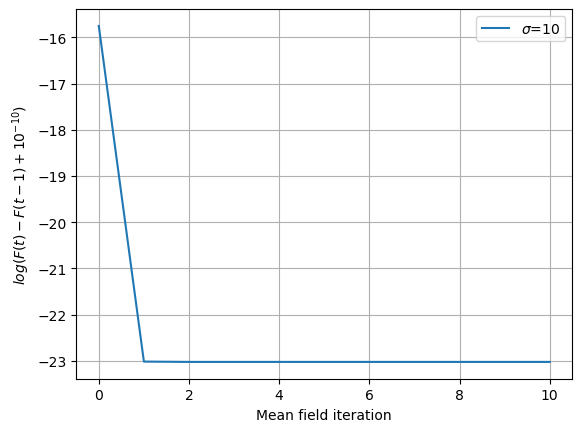

In [12]:
plt.figure()
sigma = [0.1, 5, 10]
for s in sigma:
    l, f = MeanField(Y[0,:][None, :], mu, s, pie, lambd[0,:][None,:], 100)

    # free energy
    plt.plot(f, label="$\sigma$={}".format(s))
    plt.legend()
    plt.ylabel("$F(t)$")
    plt.xlabel("Mean field iteration")
    plt.grid()
    plt.show()
    # log(f(t)-f(t-1)
    loglist = []
    for t in range(len(f)):
        if t > 0:
            loglist.append(np.log(f[t] - f[t - 1]+1e-10))
    plt.plot(loglist, label="$\sigma$={}".format(s))
    plt.legend()
    plt.ylabel("$log(F(t)-F(t-1) + 10^{-10})$")
    plt.xlabel("Mean field iteration")
    plt.grid()

    plt.show()